In [63]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [64]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [65]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [66]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 11 2022 8:34AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,8
1,Apr 11 2022 8:33AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,8
2,Apr 11 2022 8:33AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,8
3,Apr 11 2022 8:34AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,8
4,Apr 11 2022 8:36AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,8


# WAREHOUSE

In [67]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,22
1,17,8
2,18,9
3,19,7
4,20,179


In [68]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [69]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [70]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,22
17,8
18,9
19,7
20,179


### All Operations type

In [71]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Count,8
1,DRIVER CHECK IN,3
2,Lot Status Change,5
3,Manual Pick Allocation,12
4,Picking,149


In [72]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [73]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Count,8
1,DRIVER CHECK IN,3
2,Lot Status Change,5
3,Manual Pick Allocation,12
4,Picking,149


In [74]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Count,8
DRIVER CHECK IN,3
Lot Status Change,5
Manual Pick Allocation,12
Picking,149


### Excluding Operations PICKING and RECEIVING

In [75]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [76]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Count,8
DRIVER CHECK IN,3
Lot Status Change,5
Manual Pick Allocation,12
Picking Completed,17


### Operations per Hour

In [77]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,7,37
1,8,266


In [78]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [79]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
7,37
8,266


# PICKING

In [80]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [81]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,8
1,Angel Luna,8,1
2,Carl Ambroise,8,2
3,Ernest Ferguson,7,1
4,Ernest Ferguson,8,5


In [82]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8
employee,,
Aisha Cooper,0.0,8.0
Angel Luna,0.0,1.0
Carl Ambroise,0.0,2.0
Ernest Ferguson,1.0,5.0
Nelson Hurtado,0.0,9.0


### Save in JSON File

In [83]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Angel Luna,Carl Ambroise,Ernest Ferguson,Nelson Hurtado,Raul Bejarano,Shawn Saunders,Sujelin Soto-Orta,Wendy Medrano
7,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,17.0
8,8.0,1.0,2.0,5.0,9.0,7.0,6.0,1.0,90.0


### Picking By Warehouse Function

In [84]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [85]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [86]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
57,Apr 11 2022 8:32AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,8
58,Apr 11 2022 8:32AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,8
59,Apr 11 2022 8:32AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,8
60,Apr 11 2022 8:32AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,8
61,Apr 11 2022 8:32AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,8


In [87]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Carl Ambroise,8,2
1,Chris Martin,8,78
2,Sandra Vega,8,6


In [88]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,8
employee,
Carl Ambroise,2
Chris Martin,78
Sandra Vega,6


In [89]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Carl Ambroise,Chris Martin,Sandra Vega
8,2,78,6


# INVENTORY

In [90]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [91]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [92]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [93]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [94]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,20
operationCode,
Inventory Counts,8


# QUERY 02: Open Outbounds

In [95]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [96]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [97]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1719 days 23:34:59.036685
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,923 days 21:53:58.090685
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,878 days 16:07:23.440685
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,809 days 19:23:55.170685
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,809 days 19:23:54.786685


In [98]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1719 days 23:34:59.036685,1719,23
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,923 days 21:53:58.090685,923,21
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,878 days 16:07:23.440685,878,16
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,809 days 19:23:55.170685,809,19
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,809 days 19:23:54.786685,809,19


In [99]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [100]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [101]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [102]:
df_02_grouped

,orders
age_group,
24 Hours,418
48 Hours,440
72 Hours,216
1 Week,527
1 Month,1125
2 Months,691
3 Months,615
1 Year,2233
2 Years,1087


### Save in JSON File

In [103]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,418
48 Hours,440
72 Hours,216
1 Week,527
1 Month,1125
2 Months,691
3 Months,615
1 Year,2233
2 Years,1087


<AxesSubplot:ylabel='age_group'>

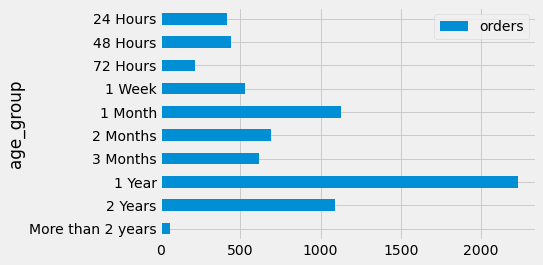

In [104]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [105]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location, o.orderClassId\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
        inner join datex_footprint.ShipmentOrderLookup sol\
        inner join datex_footprint.orders o\
            on o.id = sol.orderId\
            on sol.shipmentId = s.id\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2 and isnull(o.orderClassId, 0) not in (23, 24, 36) and s.lookupCode not like '%TEST%'\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066, 2067, 2068) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [106]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location,orderClassId
180,2022-04-11 08:18:34.360,Picking,20,Sartorius Stedim North America,FBT214178,Ernest Ferguson,SSNA-2173546796,233741,1,18-25-02-B,2
181,2022-04-11 08:19:03.920,Picking Completed,20,Sartorius Stedim North America,None,Ernest Ferguson,SSNA-2173546796,233741,1,None,2
182,2022-04-11 08:19:26.687,Picking,20,Sartorius Stedim North America,FBT214178,Ernest Ferguson,SSNA-2173546796,233741,1,18-14-03-B,2


In [107]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [108]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
0,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:36:36.303,Scanned Shipment,Shawn Saunders,None
1,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:38:47.763,Picking,Shawn Saunders,23-23-01-B
2,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:39:05.777,Picking Completed,Shawn Saunders,None
3,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:46:48.787,Picking,Shawn Saunders,23-15-01-A
4,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:33:38.290,Picking,Shawn Saunders,23-14-01-A


In [109]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
0,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:36:36.303,Scanned Shipment,Shawn Saunders,None,NaT
1,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:38:47.763,Picking,Shawn Saunders,23-23-01-B,0 days 00:02:11.460000
2,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:39:05.777,Picking Completed,Shawn Saunders,None,0 days 00:00:18.014000
3,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:46:48.787,Picking,Shawn Saunders,23-15-01-A,0 days 00:07:43.010000
4,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:33:38.290,Picking,Shawn Saunders,23-14-01-A,0 days 00:46:49.503000


In [110]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:36:36.303,Scanned Shipment,Shawn Saunders,None,NaT,NaN,NaN,NaN
1,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:38:47.763,Picking,Shawn Saunders,23-23-01-B,0 days 00:02:11.460000,0.0,2.0,11.0
2,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:39:05.777,Picking Completed,Shawn Saunders,None,0 days 00:00:18.014000,0.0,0.0,18.0
3,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:46:48.787,Picking,Shawn Saunders,23-15-01-A,0 days 00:07:43.010000,0.0,7.0,43.0
4,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:33:38.290,Picking,Shawn Saunders,23-14-01-A,0 days 00:46:49.503000,0.0,46.0,49.0


In [111]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:36:36.303,Scanned Shipment,Shawn Saunders,None,NaT,0.0,0.0,0.0
10,20,Reliable 1 Laboratories LLC,7852846,2022-04-11 07:58:13.837,Scanned Shipment,Aisha Cooper,None,-1 days +23:14:09.090000,0.0,0.0,0.0
20,19,"Innogenix, LLC",7871639,2022-04-11 08:40:42.030,Scanned Shipment,Sujelin Soto-Orta,None,-1 days +23:57:00.050000,0.0,0.0,0.0
23,19,ACG North America LLC,ACG-2102489727,2022-04-11 08:42:31.070,Scanned Shipment,Angel Luna,None,-1 days +23:59:28.330000,0.0,0.0,0.0
26,20,Alumier Labs Inc.,ALU0006561,2022-04-11 08:01:34.483,Scanned Shipment,Wendy Medrano,None,-1 days +23:17:31.053000,0.0,0.0,0.0


In [112]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
0,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:36:36.303,Scanned Shipment,Shawn Saunders,None,NaT,0.0,0.0,0.0,0.000000
1,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:38:47.763,Picking,Shawn Saunders,23-23-01-B,0 days 00:02:11.460000,0.0,2.0,11.0,2.183333
2,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:39:05.777,Picking Completed,Shawn Saunders,None,0 days 00:00:18.014000,0.0,0.0,18.0,0.300000
3,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:46:48.787,Picking,Shawn Saunders,23-15-01-A,0 days 00:07:43.010000,0.0,7.0,43.0,7.716667
4,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:33:38.290,Picking,Shawn Saunders,23-14-01-A,0 days 00:46:49.503000,0.0,46.0,49.0,46.816667


In [113]:
# Save in JSON Format for HTML
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                   Shipment               Operation         Date                             
10        Livs Products             GMM_ACV_10.990 Bottles Scanned Shipment  2022-04-11 08:25:51.243  0.000000
                                                           Picking           2022-04-11 08:26:24.747  0.550000
                                                                             2022-04-11 08:26:44.153  0.316667
                                                                             2022-04-11 08:27:00.090  0.250000
                                                           Picking Completed 2022-04-11 08:27:02.760  0.033333
                                                           Picking           2022-04-11 08:27:11.890  0.150000
                                                                             2022-04-11 08:27:27.047  0.250000
                                                                             2022-04-11 08:28:07.670  0.666667
                                                                             2022-04-11 08:28:13.923  0.100000
                                                                             2022-04-11 08:28:19.517  0.083333
                                                                             2022-04-11 08:28:36.907  0.283333
                                    Moreno Valley_Gummy    Scanned Shipment  2022-04-11 08:30:10.847  0.000000
18        Blinc International, Inc. IF-2087620             Scanned Shipment  2022-04-11 08:16:59.870  0.000000
                                                           Picking           2022-04-11 08:20:46.003  3.766667
                                                           Picking Completed 2022-04-11 08:21:03.517  0.283333
                                                           Picking           2022-04-11 08:25:43.713  4.666667
                                                                             2022-04-11 08:29:09.860  3.433333
                                                                             2022-04-11 08:31:46.833  2.600000
                                                                             2022-04-11 08:34:13.087  2.433333
                                                                             2022-04-11 08:40:11.390  5.966667

In [114]:
# Remove Operation 'Scanned Shipment'
df03_excluding_Scanned = df03_orders_modified.loc[df03_orders_modified['Operation'] != 'Scanned Shipment']
df03_excluding_Scanned.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
1,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:38:47.763,Picking,Shawn Saunders,23-23-01-B,0 days 00:02:11.460000,0.0,2.0,11.0,2.183333
2,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:39:05.777,Picking Completed,Shawn Saunders,None,0 days 00:00:18.014000,0.0,0.0,18.0,0.300000
3,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 07:46:48.787,Picking,Shawn Saunders,23-15-01-A,0 days 00:07:43.010000,0.0,7.0,43.0,7.716667
4,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:33:38.290,Picking,Shawn Saunders,23-14-01-A,0 days 00:46:49.503000,0.0,46.0,49.0,46.816667
5,20,Reliable 1 Laboratories LLC,7852845,2022-04-11 08:35:18.637,Picking,Shawn Saunders,22-14-01-A,0 days 00:01:40.347000,0.0,1.0,40.0,1.666667


In [115]:
# Testing
df03_excluding_Scanned.loc[df03_excluding_Scanned['Warehouse'] == '10']

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
151,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:26:24.747,Picking,Nelson Hurtado,Receiving,0 days 00:00:33.504000,0.0,0.0,33.0,0.550000
152,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:26:44.153,Picking,Nelson Hurtado,Receiving,0 days 00:00:19.406000,0.0,0.0,19.0,0.316667
153,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:27:00.090,Picking,Nelson Hurtado,Receiving,0 days 00:00:15.937000,0.0,0.0,15.0,0.250000
154,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:27:02.760,Picking Completed,Nelson Hurtado,None,0 days 00:00:02.670000,0.0,0.0,2.0,0.033333
155,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:27:11.890,Picking,Nelson Hurtado,Receiving,0 days 00:00:09.130000,0.0,0.0,9.0,0.150000
156,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:27:27.047,Picking,Nelson Hurtado,Receiving,0 days 00:00:15.157000,0.0,0.0,15.0,0.250000
157,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:28:07.670,Picking,Nelson Hurtado,Receiving,0 days 00:00:40.623000,0.0,0.0,40.0,0.666667
158,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:28:13.923,Picking,Nelson Hurtado,Receiving,0 days 00:00:06.253000,0.0,0.0,6.0,0.100000
159,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:28:19.517,Picking,Nelson Hurtado,Receiving,0 days 00:00:05.594000,0.0,0.0,5.0,0.083333
160,10,Livs Products,GMM_ACV_10.990 Bottles,2022-04-11 08:28:36.907,Picking,Nelson Hurtado,Receiving,0 days 00:00:17.390000,0.0,0.0,17.0,0.283333


In [116]:
# Save in CSV Format for Tableau
df03_group2 = df03_excluding_Scanned.groupby(['Warehouse', 'Project', 'Employee', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Employee', 'Shipment', 'Date'])
df03_group2.to_csv('data/performance.csv')
df03_group2.head(20)

Time
Warehouse Project                   Employee       Shipment               Operation         Date                             
10        Livs Products             Nelson Hurtado GMM_ACV_10.990 Bottles Picking           2022-04-11 08:26:24.747  0.550000
                                                                                            2022-04-11 08:26:44.153  0.316667
                                                                                            2022-04-11 08:27:00.090  0.250000
                                                                          Picking Completed 2022-04-11 08:27:02.760  0.033333
                                                                          Picking           2022-04-11 08:27:11.890  0.150000
                                                                                            2022-04-11 08:27:27.047  0.250000
                                                                                            2022-04-11 08:28:07.670  0.666667
                                                                                            2022-04-11 08:28:13.923  0.100000
                                                                                            2022-04-11 08:28:19.517  0.083333
                                                                                            2022-04-11 08:28:36.907  0.283333
18        Blinc International, Inc. Raul Bejarano  IF-2087620             Picking           2022-04-11 08:20:46.003  3.766667
                                                                          Picking Completed 2022-04-11 08:21:03.517  0.283333
                                                                          Picking           2022-04-11 08:25:43.713  4.666667
                                                                                            2022-04-11 08:29:09.860  3.433333
                                                                                            2022-04-11 08:31:46.833  2.600000
                                                                                            2022-04-11 08:34:13.087  2.433333
                                                                                            2022-04-11 08:40:11.390  5.966667
                                                                                            2022-04-11 08:42:30.103  2.300000
19        ACG North America LLC     Angel Luna     ACG-2102489727         Picking           2022-04-11 08:43:25.493  0.900000
                                                                          Picking Completed 2022-04-11 08:44:03.430  0.616667

In [117]:
# Close connection
cnxn.close()